In [20]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import hvplot.pandas
import pandas as pd
import numpy as np
import requests
import json
import scipy.stats as st
from scipy.stats import linregress

In [27]:
# Study data files- Number of fires classified by cause-NFD 
provinces_path= "DataSets_project_2/NFD-Num_fires_by_cause_EN_FR.csv"

# Read the wildfire data and the study results
ForestFire_provinces = pd.read_csv(provinces_path, encoding= "ISO-8859-1")
ForestFire_provinces.head()

,Year,Année,ISO,Jurisdiction,Juridiction,Cause,Origine,Number,Data Qualifier,Nombre,Qualificatifs de données
0,1990,1990,AB,Alberta,Alberta,Human activity,Activités humaines,379.0,a,379.0,a
1,1990,1990,AB,Alberta,Alberta,Lightning,Foudre,971.0,a,971.0,a
2,1990,1990,AB,Alberta,Alberta,Unspecified,Indéterminée,16.0,a,16.0,a
3,1990,1990,BC,British Columbia,Colombie-Britannique,Human activity,Activités humaines,1240.0,a,1240.0,a
4,1990,1990,BC,British Columbia,Colombie-Britannique,Lightning,Foudre,2015.0,a,2015.0,a


In [28]:
#Data cleaning: The columns are in english and french, removing the data in french 

#Renaming the columns as they have same name 
ForestFire_provinces.rename(columns={"Jurisdiction":"Jurisdiction", "Juridiction" : "Juridiction-FR"}, inplace=True) 

In [29]:
#Removing the columns with data in French
ForestFire_provinces.drop(ForestFire_provinces.columns[[1, 4, 6, 9, 10]], axis = 1, inplace=True)


In [32]:
ForestFire_provinces

,Year,ISO,Jurisdiction,Cause,Number,Data Qualifier
0,1990,AB,Alberta,Human activity,379.0,a
1,1990,AB,Alberta,Lightning,971.0,a
2,1990,AB,Alberta,Unspecified,16.0,a
3,1990,BC,British Columbia,Human activity,1240.0,a
4,1990,BC,British Columbia,Lightning,2015.0,a
...,...,...,...,...,...,...
1054,2021,PC,Parks Canada,Unspecified,73.0,e
1055,2021,PE,Prince Edward Island,Unspecified,1.0,e
1056,2021,QC,Quebec,Unspecified,625.0,e
1057,2021,SK,Saskatchewan,Unspecified,635.0,e


In [63]:
#Removing 2021 data : the data from 2021 is not very clear and most of its categories are Unspecified
ForestFire_provinces = ForestFire_provinces[ForestFire_provinces["Year"] != 2021]

In [64]:
#To find the total number of fires by Jurisdiction: Group the data by Jurisdiction
Sum_fire_Prov = ForestFire_provinces.groupby(["Jurisdiction"]).sum()

#Removing Year column
Sum_fire_Prov.drop(["Year"], axis =1, inplace = True)

#Renaming the column
Sum_fire_Prov.rename(columns  = {"Number":"Tot_Forest_Fires"}, inplace=True)

C:\Users\nikit\AppData\Local\Temp\ipykernel_22740\315044350.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Sum_fire_Prov = ForestFire_provinces.groupby(["Jurisdiction"]).sum()


In [65]:
Sum_fire_Prov

,Tot_Forest_Fires
Jurisdiction,
Alberta,40315.0
British Columbia,57893.0
Manitoba,14046.0
New Brunswick,10480.0
Newfoundland and Labrador,3150.0
Northwest Territories,7438.0
Nova Scotia,9051.0
Ontario,35770.0
Prince Edward Island,549.0


In [66]:
ISO = ForestFire_provinces["ISO"].unique()
Sum_fire_Prov["ISO"] = ISO

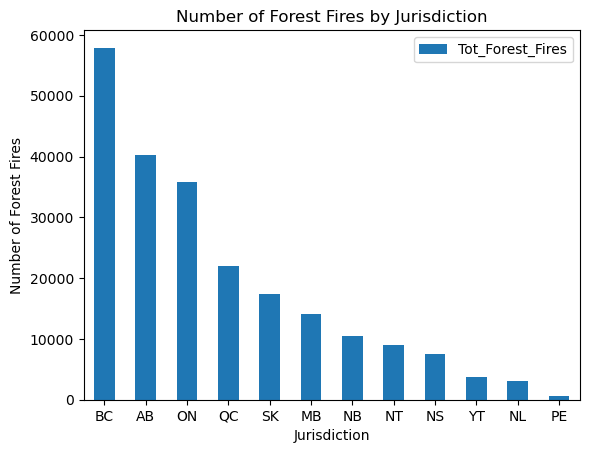

In [84]:
# Generate a bar plot showing the total number of forest fire for each Jurisdiction.
Sum_fire_Prov_SV = Sum_fire_Prov.sort_values(["Tot_Forest_Fires"], ascending = False).reset_index()
Fig1_Total_Wildfire_by_Province_NG = Sum_fire_Prov_SV.plot.bar(x= "ISO", y="Tot_Forest_Fires", rot = 0);

# Incorporate the other graph properties
plt.title("Number of Forest Fires by Jurisdiction")
plt.ylabel("Number of Forest Fires")
plt.xlabel("Jurisdiction")

# Save the figure
plt.savefig("Output_data_NG/Fig1_Total_Wildfire_by_Province_NG.png")

#Show plot
plt.show(block=True);


# Observation and Analysis:
    - In the past 31 years, British Columbia has experienced the maximum number of forest fires, followed by Alberta and Ontario
    -The Jurisdiction with least number of Wildfires are Prince Edward Island, Newfoundland and Labrador and Yukon
    

In [68]:
#Adding capital cities for each Jurisdiction to get their geolocations(Latitude and longitude)
Capital_Cities = ["Edmonton", "Victoria", "Winnipeg", "Fredericton", "St. John's", "Yellowknife", "Halifax",
                 "Toronto", "Charlottetown", "Montréal", "Regina", "Whitehorse"]

In [78]:
#Adding capital cities and blank columns to get Latitude and longitude values for each Jurisdiction 
Sum_fire_Prov["Capital Cities"] = Capital_Cities 
Sum_fire_Prov["Longitude"] = ""
Sum_fire_Prov["Latitude"] = ""

#Display the sample data
Sum_fire_Prov

,Jurisdiction,Tot_Forest_Fires,ISO,Capital Cities,Longitude,Latitude
0,Alberta,40315.0,AB,Edmonton,,
1,British Columbia,57893.0,BC,Victoria,,
2,Manitoba,14046.0,MB,Winnipeg,,
3,New Brunswick,10480.0,NB,Fredericton,,
4,Newfoundland and Labrador,3150.0,NL,St. John's,,
5,Northwest Territories,7438.0,NS,Yellowknife,,
6,Nova Scotia,9051.0,NT,Halifax,,
7,Ontario,35770.0,ON,Toronto,,
8,Prince Edward Island,549.0,PE,Charlottetown,,
9,Quebec,22010.0,QC,Montréal,,


In [79]:
#Set the API base URL
base_url = "https://geogratis.gc.ca/services/geoname/en/geonames.json?q="

# Loop through all the capital cities in our list to fetch their locations
for index, row in Sum_fire_Prov.iterrows():
    city = row["Capital Cities"]
    Query_url = base_url + city
    geo_data = requests.get(Query_url).json()
    
    # extract results and add it in the dataframe   
    Sum_fire_Prov.loc[index, 'Longitude'] = geo_data["items"][0]["longitude"]
    Sum_fire_Prov.loc[index, 'Latitude'] = geo_data["items"][0]["latitude"]
    
#Display the dataframe
Sum_fire_Prov

,Jurisdiction,Tot_Forest_Fires,ISO,Capital Cities,Longitude,Latitude
0,Alberta,40315.0,AB,Edmonton,-113.490278,53.534444
1,British Columbia,57893.0,BC,Victoria,-123.364722,48.428333
2,Manitoba,14046.0,MB,Winnipeg,-97.146389,49.884444
3,New Brunswick,10480.0,NB,Fredericton,-66.666667,45.945278
4,Newfoundland and Labrador,3150.0,NL,St. John's,-52.797069,47.482197
5,Northwest Territories,7438.0,NS,Yellowknife,-114.37,62.4536
6,Nova Scotia,9051.0,NT,Halifax,-63.590651,44.647401
7,Ontario,35770.0,ON,Toronto,-79.3733,43.7417
8,Prince Edward Island,549.0,PE,Charlottetown,-63.134722,46.240278
9,Quebec,22010.0,QC,Montréal,-73.554077,45.508822


In [90]:
# Configure the map plot_1- size of the spots is based on the total number of fire
Geo_plot_1_NG= Sum_fire_Prov.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "StamenToner",
    frame_width = 700,
    frame_height = 500,
    size = "Tot_Forest_Fires",
    scale = 0.2,
    color = "Jurisdiction",
    attr_labels = True)

# Display the map
Geo_plot_1_NG

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Jurisdiction,Tot_Forest_Fires)

In [82]:
# Configure the map plot_2 : try different views(size of the spots is based on the total number of fire)
map_plot_2= Sum_fire_Prov.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "StamenTerrain",
    frame_width = 700,
    frame_height = 500,
    size = "Tot_Forest_Fires",
    scale = 0.2,
    color = "Jurisdiction",
    attr_labels = True)


# Display the map
map_plot_2

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Jurisdiction,Tot_Forest_Fires)

# Observation and Analysis:
    - Jurisdiction with the maximum number of Wildfires were located at the south of Canada. There could be possibly three reasons for that:
    1)These Jurisdiction are warmer as compared to the Jurisdictions locted in the North of Canada
    2)The population density could be one the possible cause of wildfires in these Jurisdictions
    3)Area covered with Forest could be more in the Jurisdiction with high number of fires due to warmer temeprature conditions
    
Further analysis was performed to understand the cause of these wildfires    

In [93]:
#Using ForestFire_provinces dataframe to categorize wildfire based on Causes
ForestFire_provinces.drop(["Data Qualifier"], axis =1, inplace = True)

#Rename column 
ForestFire_provinces=ForestFire_provinces.rename(columns= {"Number":"Num of Fires"})

ForestFire_provinces

,Year,ISO,Jurisdiction,Cause,Num of Fires
0,1990,AB,Alberta,Human activity,379.0
1,1990,AB,Alberta,Lightning,971.0
2,1990,AB,Alberta,Unspecified,16.0
3,1990,BC,British Columbia,Human activity,1240.0
4,1990,BC,British Columbia,Lightning,2015.0
...,...,...,...,...,...
1041,2020,SK,Saskatchewan,Human activity,136.0
1042,2020,SK,Saskatchewan,Lightning,24.0
1043,2020,SK,Saskatchewan,Unspecified,41.0
1044,2020,YT,Yukon,Human activity,11.0


In [94]:
#Creating Dataframes based on different causes
#Human Activites
Human_activity=ForestFire_provinces['Cause']=='Human activity'
HA_df= ForestFire_provinces[Human_activity]
HA_df_prov = HA_df.groupby(["Jurisdiction"])["Num of Fires"].sum().reset_index()

#Lightning
Lightning=ForestFire_provinces['Cause']=='Lightning'
Lightning_df = ForestFire_provinces[Lightning]
Lightning_df_prov = Lightning_df.groupby(["Jurisdiction"])["Num of Fires"].sum().reset_index()

#Unspecified
Unspecified=ForestFire_provinces['Cause']=='Unspecified'
Unspecified_df = ForestFire_provinces[Unspecified]
Unspecified_df_prov = Unspecified_df.groupby(["Jurisdiction"])["Num of Fires"].sum().reset_index()

#Prescribed burn
PB=ForestFire_provinces['Cause']=='Prescribed burn'
PB_df = ForestFire_provinces[PB]
PB_df_prov = PB_df.groupby(["Jurisdiction"])["Num of Fires"].sum().reset_index()

In [95]:
#Merging all the files:used outer as the category "prescibed burn" data was not present for each Jurisdiction
Merge_1 = HA_df_prov.merge(Lightning_df_prov, how ="outer", on="Jurisdiction")

#Rename columns to avoid confusion
Merge_1 = Merge_1.rename(columns={"Num of Fires_x":"Human Activities", 
                                      "Num of Fires_y":"Lightning"})
Merge_2 = Merge_1.merge(Unspecified_df_prov, how ="outer", on="Jurisdiction")
Merge_3 = Merge_2.merge(PB_df_prov, how ="outer", on="Jurisdiction")

#Rename columns
Final_merged = Merge_3.rename(columns={"Num of Fires_x": "Unspecified",
                                      "Num of Fires_y": "Prescribed burn"})

#Replace NaN values with 0
Final_merged = Final_merged.fillna(0)
Final_merged["ISO"] = ISO

#display the dataframe
Final_merged

,Jurisdiction,Human Activities,Lightning,Unspecified,Prescribed burn,ISO
0,Alberta,21316.0,17798.0,1041.0,86.0,AB
1,British Columbia,24166.0,33535.0,174.0,18.0,BC
2,Manitoba,4887.0,6280.0,2859.0,20.0,MB
3,New Brunswick,8237.0,954.0,1289.0,0.0,NB
4,Newfoundland and Labrador,2787.0,318.0,39.0,6.0,NL
5,Northwest Territories,887.0,6408.0,102.0,41.0,NS
6,Nova Scotia,7400.0,207.0,1434.0,10.0,NT
7,Ontario,16457.0,18579.0,692.0,42.0,ON
8,Prince Edward Island,407.0,1.0,141.0,0.0,PE
9,Quebec,14512.0,7466.0,1.0,31.0,QC


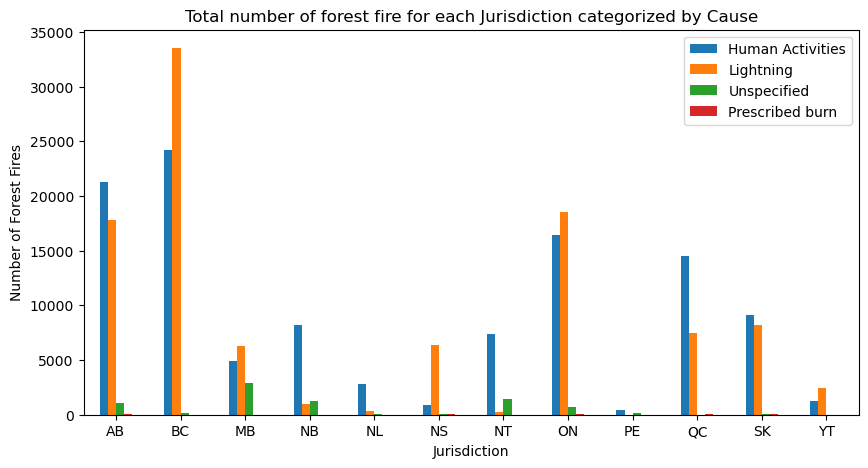

In [97]:
# Generate a bar plot showing the total number of forest fire for each Jurisdiction categorized by Cause
Fig2_Wildfire_byCause_eachProvince_NG = Final_merged.plot(kind="bar", x = "ISO", figsize=(10,5), rot = 0 )

# Incorporate the other graph properties
plt.title("Total number of forest fire for each Jurisdiction categorized by Cause")
plt.ylabel("Number of Forest Fires")
plt.xlabel("Jurisdiction")

# Save the figure
plt.savefig("Output_data_NG/Fig2_Wildfire_byCause_eachProvince_NG.png")

#Show plot
plt.show(block=True);


# Observation and Analysis:
    - The major cause of wildfire in British Columbia and Nova Scotia is lightning
    - On the contrary, In Alberta, New Brunswick and Qubec, the main cause of wildfire is Human Activities
    - Most of the Wildfires are accumulated towards the south of Canada, 
        -This could be of because the Higher Population density in these areas leading to increased cases of wildfire due to human activities
        
Since, Human Activities was one of the major cause of wildfire, so I thought to correlate it with the CO2 emmision data over the years

In [91]:
#Calculate total number of fires each year
Sum_fire_years = ForestFire_provinces.groupby(["Year"]).sum()
Sum_fire_years = Sum_fire_years.rename(columns={"Number": "Tot. Fires"})
Sum_fire_years

C:\Users\nikit\AppData\Local\Temp\ipykernel_22740\3289383486.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Sum_fire_years = ForestFire_provinces.groupby(["Year"]).sum()


,Tot. Fires
Year,
1990,10010.0
1991,10231.0
1992,8994.0
1993,5977.0
1994,9679.0
1995,8445.0
1996,6379.0
1997,6090.0
1998,10768.0


In [20]:
#Calculate total number of fires for 31 years in Canada
Total_Forest_fire = Sum_fire_years["Tot. Fires"].sum()
Total_Forest_fire

221806.0

In [99]:
# Study data files: Imported the data from global forest watch for Canada to get the Co2 emission data 
CO2_path= "DataSets_project_2/clean_deforestation.csv"

# Read the mouse data and the study results
CO2_emmission_df = pd.read_csv(CO2_path)

CO2_emmission_df

,Unnamed: 0,Driver,Year,Area (ha),Co2 Emissions (mg)
0,0,Unknown,2012,2.024898e+04,6.180339e+06
1,2,Shifting agriculture,2019,3.902074e+02,1.180400e+05
2,3,Forestry,2020,8.241403e+05,2.818487e+08
3,4,Unknown,2019,9.083234e+03,2.341594e+06
4,5,Forestry,2005,1.265036e+06,3.409206e+08
...,...,...,...,...,...
115,127,Unknown,2004,1.529486e+04,4.158354e+06
116,128,Shifting agriculture,2017,4.191385e+02,1.167649e+05
117,129,Wildfire,2008,1.108305e+06,4.664998e+08
118,130,Wildfire,2018,9.524899e+05,4.214107e+08


In [100]:
#Grouped data by years 
CO2_emmission_Year = CO2_emmission_df.groupby(["Year"])

#Created a dataframe with only Co2 Emissions (mg) per year
Co2_emmision_by_year = CO2_emmission_Year["Co2 Emissions (mg)"].sum()
Co2_emmision_by_year = pd.DataFrame(Co2_emmision_by_year)
Co2_emmision_by_year

,Co2 Emissions (mg)
Year,
2001,4.191191e+08
2002,8.406335e+08
2003,5.631612e+08
2004,9.256662e+08
2005,9.711948e+08
2006,8.547962e+08
2007,7.831378e+08
2008,7.312341e+08
2009,5.263068e+08


In [101]:
# Merging Co2 emmission data with total no.of fires each year dataframe: Used inner join as the data for Co2 emmision is 
#only present for 2001-2020
Co2_merged_Tot_fires = Co2_emmision_by_year.merge(Sum_fire_years, how ="inner", on="Year")
Co2_merged_Tot_fires.reset_index(inplace=True)

#view the merged file
Co2_merged_Tot_fires

,Year,Co2 Emissions (mg),Tot. Fires
0,2001,4.191191e+08,7762.0
1,2002,8.406335e+08,7878.0
2,2003,5.631612e+08,8270.0
3,2004,9.256662e+08,6488.0
4,2005,9.711948e+08,7452.0
5,2006,8.547962e+08,9754.0
6,2007,7.831378e+08,6919.0
7,2008,7.312341e+08,6239.0
8,2009,5.263068e+08,7145.0
9,2010,7.801040e+08,7316.0


In [108]:
Years = Co2_merged_Tot_fires["Year"].unique()
Years

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

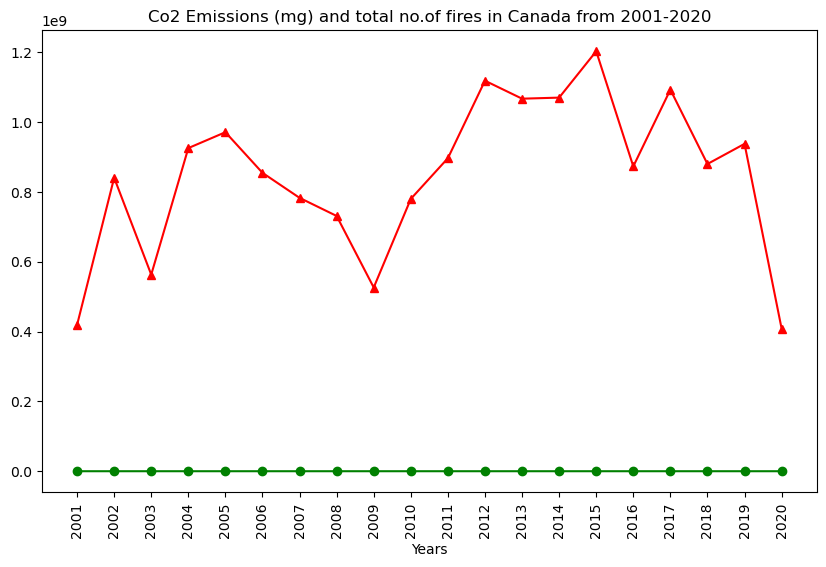

In [117]:
# Generate a line plot of Co2 emmission data and total no.of fires 
plt.figure(figsize=(10,6))
x_axis = Co2_merged_Tot_fires["Year"]
y_axis_1 = Co2_merged_Tot_fires["Tot. Fires"]
y_axis_2 = Co2_merged_Tot_fires["Co2 Emissions (mg)"]

x_axis = np.arange(0, len(Co2_merged_Tot_fires))
tick_locations = [year for year in x_axis]

plt.plot(x_axis, y_axis_1, marker = "o", color = "green", label='Total number of Wildfire')
plt.plot(x_axis, y_axis_2, marker = "^", color = "red", label='Co2 Emissions (mg)')
plt.xticks(tick_locations , Years, rotation="vertical")


# Incorporate the other graph properties
plt.title("Co2 Emissions (mg) and total no.of fires in Canada from 2001-2020")
plt.xlabel("Years")


# Save the figure
plt.savefig("Output_data_NG/Fig3_Co2 Emissions (mg) and total no.of fires in Canada from 2001-2020_NG.png")

plt.show()

#Because the value of for the CO2 emission is very high as compared to total number of fires the Total number of fire 
#looks like a straight line

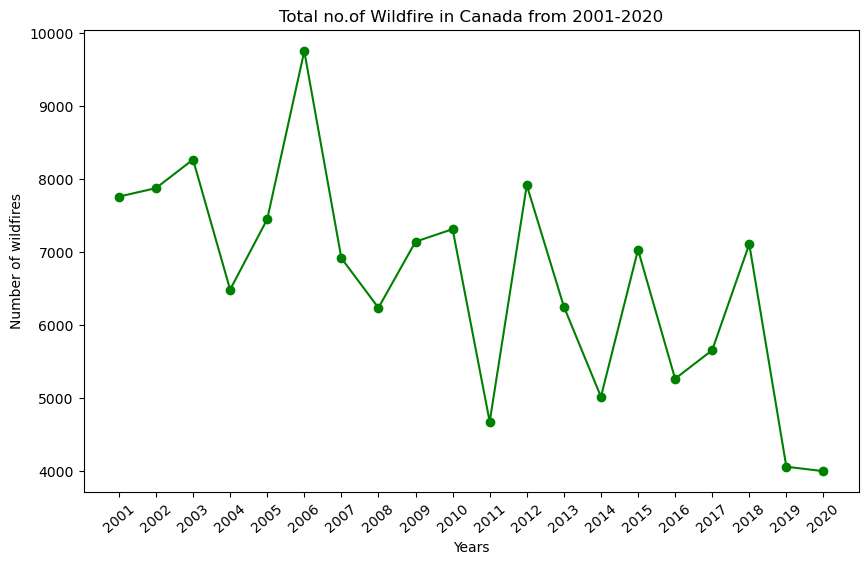

In [122]:
# Plot both the values separately
#Wildfire by year
plt.figure(figsize=(10,6))
plt.plot(x_axis, y_axis_1, marker = "o", color = "green", label='Total number of Wildfire')
plt.xticks(tick_locations , Years, rotation=40)

plt.title("Total no.of Wildfire in Canada from 2001-2020")
plt.xlabel("Years")
plt.ylabel("Number of wildfires")

# Save the figure
plt.savefig("Output_data_NG/Fig4_Total no.of Wildfire in Canada from 2001-2020.png")


plt.show()

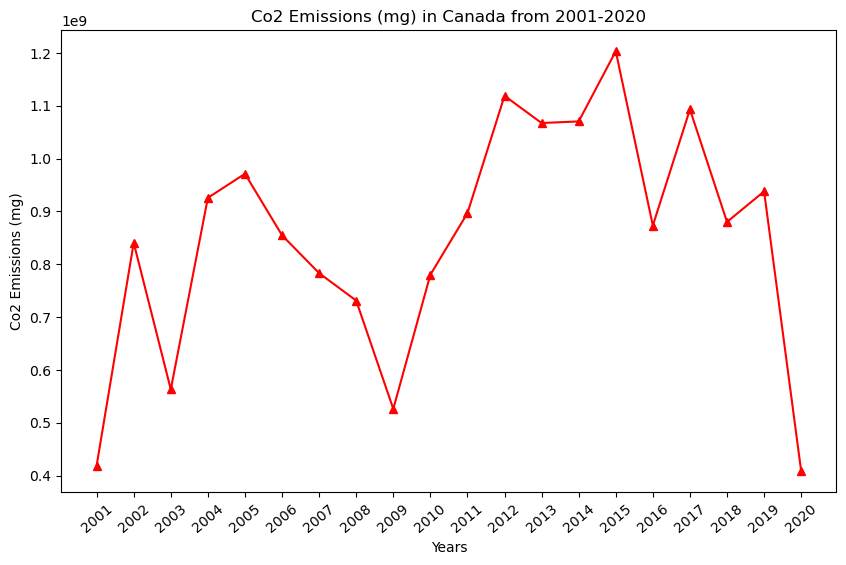

In [126]:
# Plot both the values separately
#Co2 Emissions (mg) by year
plt.figure(figsize=(10,6))
plt.plot(x_axis, y_axis_2, marker = "^", color = "red", label='Co2 Emissions (mg)')
plt.xticks(tick_locations , Years, rotation=40)

plt.title("Co2 Emissions (mg) in Canada from 2001-2020")
plt.xlabel("Years")
plt.ylabel("Co2 Emissions (mg)")

# Save the figure
plt.savefig("Output_data_NG/Fig5_Co2 Emissions (mg) in Canada from 2001-2020.png")

plt.show()

The correlation between Forest Fires and Co2 Emissions (mg) is -0.06


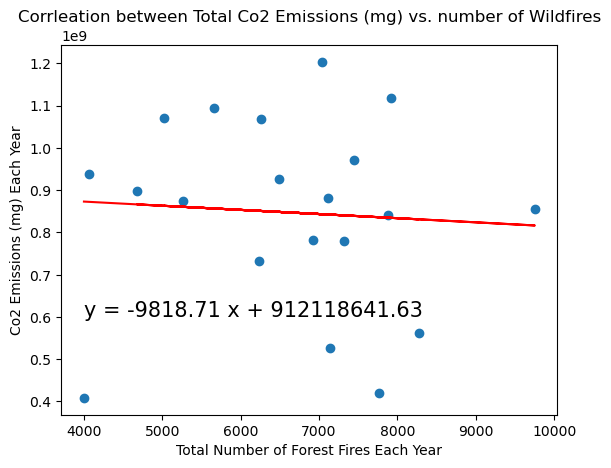

In [136]:
# Calculate the correlation coefficient and a linear regression model 
corr_coeff = st.pearsonr(Co2_merged_Tot_fires["Tot. Fires"],Co2_merged_Tot_fires["Co2 Emissions (mg)"])
print(f"The correlation between Forest Fires and Co2 Emissions (mg) is {round(corr_coeff[0], 2)}")

# Perform a linear regression for Co2 Emissions (mg) vs. Total number of Wildfires:
(slope, intercept,rvalue, pvalue, stderr)=st.linregress(Co2_merged_Tot_fires["Tot. Fires"],Co2_merged_Tot_fires["Co2 Emissions (mg)"])
regress_values=Co2_merged_Tot_fires["Tot. Fires"]* slope + intercept

# Create line equation string:
line_eq= f"y = {round(slope, 2)} x + {round(intercept, 2)}"

# Create plot:
plt.scatter(Co2_merged_Tot_fires["Tot. Fires"],Co2_merged_Tot_fires["Co2 Emissions (mg)"])
plt.plot(Co2_merged_Tot_fires["Tot. Fires"], regress_values, color='red')

# Incorporate the other graph properties:
plt.annotate(line_eq,(4000, 6.0e+08), fontsize=15)
plt.xlabel('Total Number of Forest Fires Each Year')
plt.ylabel('Co2 Emissions (mg) Each Year')
plt.title("Corrleation between Total Co2 Emissions (mg) vs. number of Wildfires")

# Save the figure:
plt.savefig('Output_data_NG/Fig.6 - Co2 Emissions (mg) vs. Total number of Wildfires.png')
plt.show()


# Observation and Analysis:
    - There no coreelation between the wildfire and Total Co2 Emissions (mg) during the years
    
Therefore, we sorted data to see if the Co2 emission due to wildfire corelates with the number of total wild fires 

In [129]:
#New dataframe with Co2 emmisions due to wildfires
CO2_emmi_due_WF = CO2_emmission_df.loc[CO2_emmission_df["Driver"]=="Wildfire",:]
CO2_emmi_due_WF = CO2_emmi_due_WF. sort_values(["Year"])
CO2_emmi_due_WF.head()

,Unnamed: 0,Driver,Year,Area (ha),Co2 Emissions (mg)
80,88,Wildfire,2001,5.147629e+05,1.993288e+08
39,43,Wildfire,2002,1.268989e+06,5.191965e+08
91,100,Wildfire,2003,8.179259e+05,3.387667e+08
86,94,Wildfire,2004,1.427605e+06,5.714145e+08
83,91,Wildfire,2005,1.631852e+06,6.227109e+08


In [130]:
# Merging Co2 emmission data with total no.of fires each year dataframe: Used inner join as the data for Co2 emmision is 
#only present for 2001-2020
CO2_emmi_due_WF_merged = CO2_emmi_due_WF.merge(Sum_fire_years, how ="inner", on="Year")
CO2_emmi_due_WF_merged.head()

,Unnamed: 0,Driver,Year,Area (ha),Co2 Emissions (mg),Tot. Fires
0,88,Wildfire,2001,5.147629e+05,1.993288e+08,7762.0
1,43,Wildfire,2002,1.268989e+06,5.191965e+08,7878.0
2,100,Wildfire,2003,8.179259e+05,3.387667e+08,8270.0
3,94,Wildfire,2004,1.427605e+06,5.714145e+08,6488.0
4,91,Wildfire,2005,1.631852e+06,6.227109e+08,7452.0


In [131]:
#Since the magnitude of Co2 emmission data with total no.of fires is very different, performed a log2 transformation 
#bring the value to same magnitude
CO2_emmi_due_WF_merged['logarithm_base2_Co2'] = np.log2(CO2_emmi_due_WF_merged['Co2 Emissions (mg)'])
CO2_emmi_due_WF_merged['logarithm_base2_Fires'] = np.log2(CO2_emmi_due_WF_merged['Tot. Fires'])
CO2_emmi_due_WF_merged.head()

,Unnamed: 0,Driver,Year,Area (ha),Co2 Emissions (mg),Tot. Fires,logarithm_base2_Co2,logarithm_base2_Fires
0,88,Wildfire,2001,5.147629e+05,1.993288e+08,7762.0,27.570575,12.922213
1,43,Wildfire,2002,1.268989e+06,5.191965e+08,7878.0,28.951705,12.943614
2,100,Wildfire,2003,8.179259e+05,3.387667e+08,8270.0,28.335717,13.013672
3,94,Wildfire,2004,1.427605e+06,5.714145e+08,6488.0,29.089962,12.663558
4,91,Wildfire,2005,1.631852e+06,6.227109e+08,7452.0,29.213987,12.863412


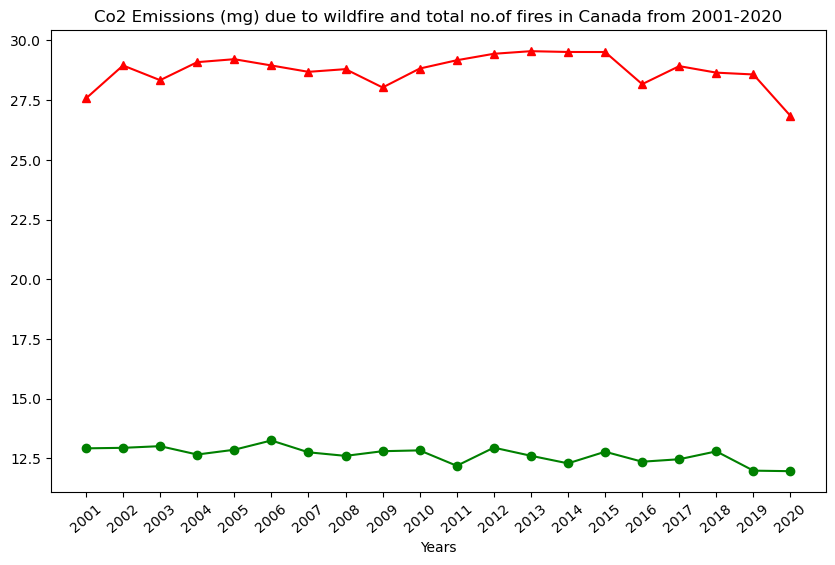

In [132]:
# Generate a line plot of Co2 emmission data and total no.of fires 
plt.figure(figsize=(10,6))

y_axis_1 = CO2_emmi_due_WF_merged["logarithm_base2_Fires"]
y_axis_2 = CO2_emmi_due_WF_merged["logarithm_base2_Co2"]

x_axis = np.arange(0, len(CO2_emmi_due_WF_merged))
tick_locations = [year for year in x_axis]

plt.plot(x_axis, y_axis_1, marker = "o", color = "green", label='Total number of Wildfire-log transformed')
plt.plot(x_axis, y_axis_2, marker = "^", color = "red", label='Co2 Emissions (mg) due to wildfire-log transformed')
plt.xticks(tick_locations , Years, rotation=40)


# Incorporate the other graph properties
plt.title("Co2 Emissions (mg) due to wildfire and total no.of fires in Canada from 2001-2020")
plt.xlabel("Years")


# Save the figure
plt.savefig("Output_data_NG/Fig7_Co2 Emissions due to wildfire and total no.of fires in Canada from 2001-2020_Log-Tranformed_NG.png")

plt.show()

#Because the value of for the CO2 emission is very high as compared to total number of fires the Total number of fire 
#looks like a straight line

The correlation between Forest Fires and Co2 Emissions (mg) is 0.23


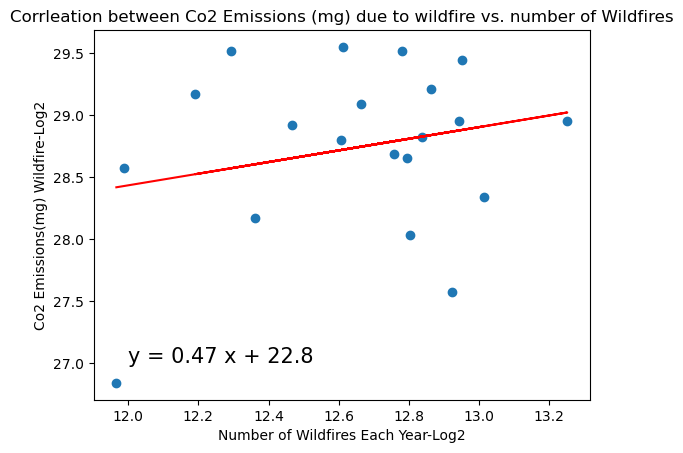

In [137]:
# Calculate the correlation coefficient and a linear regression model 
corr_coeff = st.pearsonr(CO2_emmi_due_WF_merged["logarithm_base2_Fires"],CO2_emmi_due_WF_merged["logarithm_base2_Co2"])
print(f"The correlation between Forest Fires and Co2 Emissions (mg) is {round(corr_coeff[0], 2)}")

# Perform a linear regression for Co2 Emissions (mg) vs. Total number of Wildfires:
(slope, intercept,rvalue, pvalue, stderr)=st.linregress(CO2_emmi_due_WF_merged["logarithm_base2_Fires"],CO2_emmi_due_WF_merged["logarithm_base2_Co2"])
regress_values=CO2_emmi_due_WF_merged["logarithm_base2_Fires"]* slope + intercept

# Create line equation string:
line_eq= f"y = {round(slope, 2)} x + {round(intercept, 2)}"

# Create plot:
plt.scatter(CO2_emmi_due_WF_merged["logarithm_base2_Fires"],CO2_emmi_due_WF_merged['logarithm_base2_Co2'])
plt.plot(CO2_emmi_due_WF_merged["logarithm_base2_Fires"], regress_values, color='red')

# Incorporate the other graph properties:
plt.xlabel('Number of Wildfires Each Year-Log2')
plt.ylabel('Co2 Emissions(mg) Wildfire-Log2')
plt.annotate(line_eq,(12, 27), fontsize=15)
plt.title("Corrleation between Co2 Emissions (mg) due to wildfire vs. number of Wildfires")

# Save the figure:
plt.savefig('Output_data_NG/Fig.8 - Corrleation between Co2 Emissions (mg) due to wildfire vs. Total number of Wildfires.png')
plt.show()


# Observation and Analysis:
    - There was a very weak correlation between Co2 Emissions (mg) due to wildfire vs. number of Wildfires

# Objective:
    - To correlate the wildfire data with the months- to get an understanding if the wildfires are due to temperature

In [138]:
# Study data files
ForestFire_month_path = "DataSets_project_2/Number_of_fires_by_month_Data.csv"

# Read the mouse data and the study results
ForestFire_months = pd.read_csv(ForestFire_month_path, delimiter = "\t", encoding= "utf-16")

ForestFire_months.columns = ForestFire_months.iloc[0]
ForestFire_months = ForestFire_months.iloc[1:].reset_index(drop=True)

ForestFire_months.head()

,Jurisdiction,Month,Data Qualifier,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,...,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0
0,Alberta,January,a,1.0,9.0,14.0,8.0,4.0,10.0,1.0,...,14.0,1.0,9.0,2.0,7.0,4.0,4.0,17.0,1.0,NaN
1,Alberta,February,a,5.0,4.0,11.0,12.0,NaN,6.0,NaN,...,3.0,3.0,NaN,4.0,12.0,4.0,NaN,1.0,1.0,NaN
2,Alberta,March,a,8.0,8.0,61.0,29.0,12.0,29.0,1.0,...,32.0,9.0,11.0,32.0,62.0,14.0,19.0,34.0,4.0,NaN
3,Alberta,April,a,26.0,111.0,110.0,52.0,64.0,57.0,26.0,...,123.0,37.0,81.0,277.0,287.0,101.0,97.0,188.0,68.0,NaN
4,Alberta,May,a,114.0,201.0,91.0,242.0,132.0,215.0,56.0,...,456.0,529.0,360.0,505.0,250.0,348.0,454.0,315.0,209.0,NaN


In [139]:
#Cleaning the data
#Replacing NaN values with 0
ForestFire_months = ForestFire_months.fillna(0)

#Removed the data for the year 2021 as it was incomplete
ForestFire_months = ForestFire_months.drop(2021.0, axis=1)

In [140]:
#Grouped the dataframe based on "Month" and calculated the total
Sum_FF_months = ForestFire_months.groupby(["Month"]).sum()

C:\Users\nikit\AppData\Local\Temp\ipykernel_22740\2049578780.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Sum_FF_months = ForestFire_months.groupby(["Month"]).sum()


In [141]:
Sum_FF_months.head()

,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
Month,,,,,,,,,,,,,,,,,,,,,
April,620.0,1105.0,526.0,499.0,645.0,538.0,235.0,347.0,996.0,795.0,...,338.0,905.0,458.0,299.0,580.0,942.0,314.0,362.0,399.0,436.0
August,3285.0,2674.0,2807.0,738.0,2907.0,1246.0,1201.0,1583.0,2646.0,1768.0,...,979.0,1422.0,1632.0,1204.0,815.0,784.0,1636.0,1440.0,640.0,851.0
December,5.0,10.0,5.0,5.0,10.0,1.0,4.0,34.0,12.0,37.0,...,6.0,1.0,3.0,4.0,11.0,5.0,3.0,6.0,7.0,10.0
February,8.0,12.0,14.0,29.0,3.0,11.0,4.0,2.0,3.0,3.0,...,2.0,5.0,3.0,4.0,6.0,19.0,8.0,0.0,2.0,3.0
January,1.0,18.0,20.0,13.0,13.0,15.0,7.0,1.0,3.0,6.0,...,4.0,17.0,2.0,10.0,2.0,10.0,5.0,5.0,18.0,2.0


In [142]:
#Created a column in the dataframe to calculte the total number of fires for each month
Sum_FF_months.loc[:,'Total'] = Sum_FF_months.sum(axis=1)

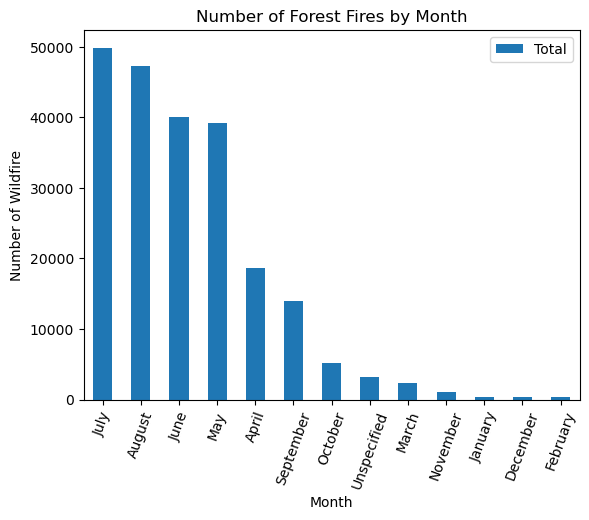

In [145]:
#Create a bar graph to see the moths with maximum number of wildfires
Sum_FF_months = Sum_FF_months.sort_values(by=['Total'], ascending=False)
Sum_FF_months.plot.bar(y="Total", rot=70, title="Number of Forest Fires by Month");

# Incorporate the other graph properties:
plt.ylabel('Number of Wildfire')

# Save the figure:
plt.savefig('Output_data_NG/Fig.9 - Number of Forest Fires by Month.png')
plt.show()


In [147]:
#Created a column in the dataframe to calculte the total number of fires for each month
ForestFire_months.loc[:,'Total'] = ForestFire_months.sum(axis=1)

C:\Users\nikit\AppData\Local\Temp\ipykernel_22740\771194899.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ForestFire_months.loc[:,'Total'] = ForestFire_months.sum(axis=1)


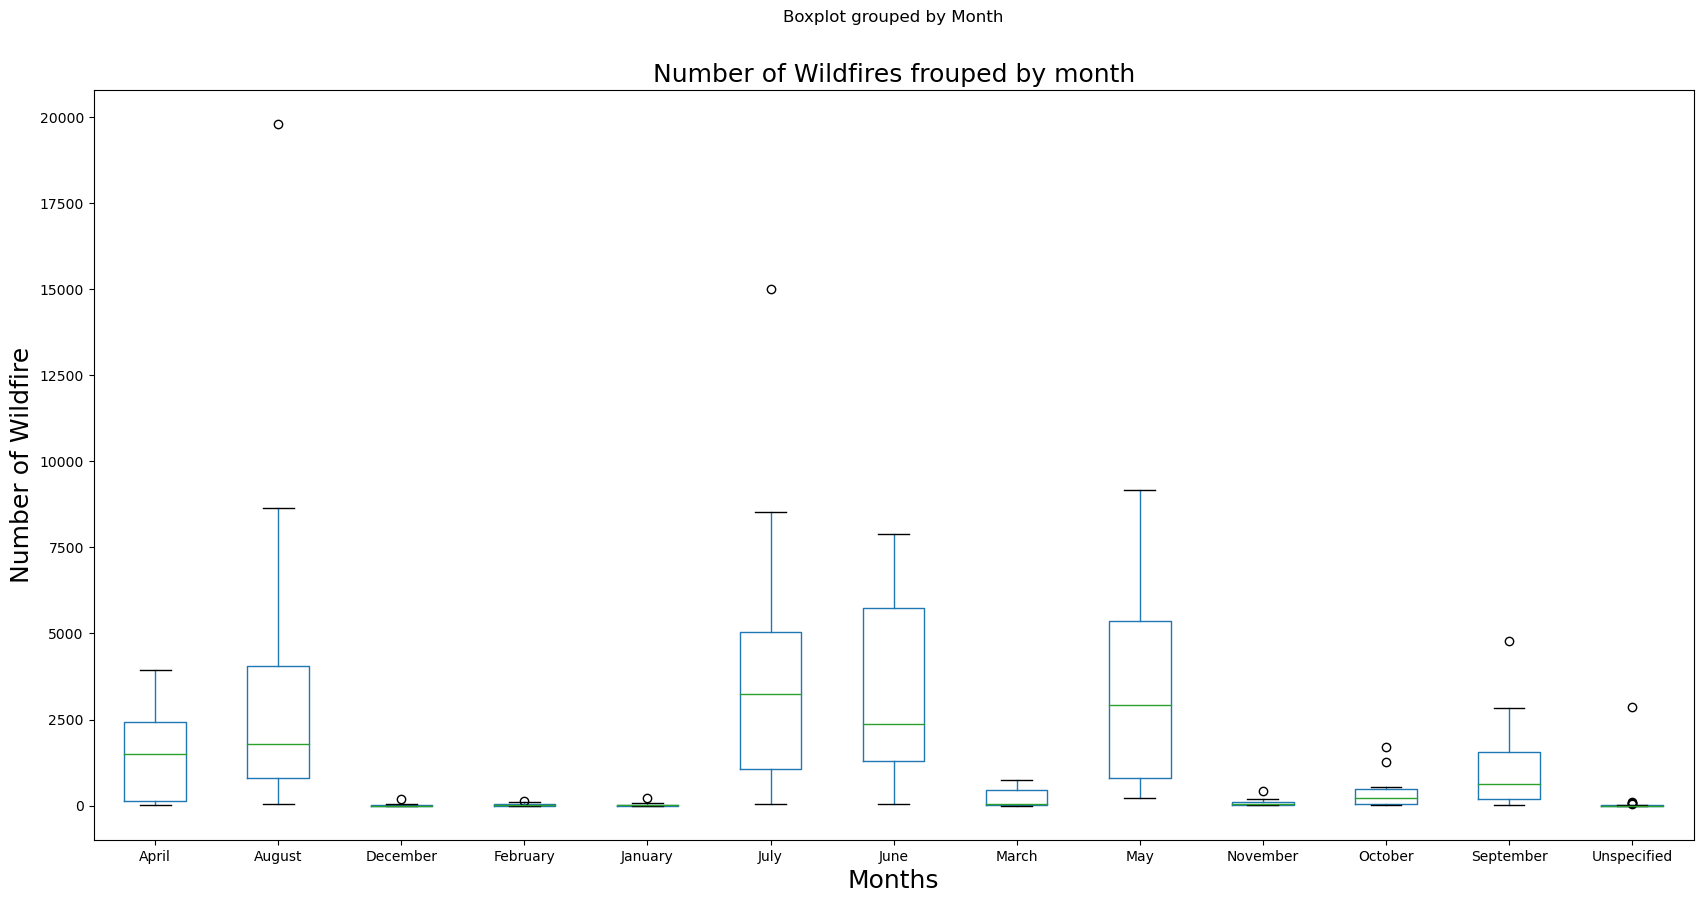

In [158]:
#Create a box-plot to see the variance in the data across each months and to check if there are any outliers
ForestFire_months.boxplot("Total", by="Month", figsize=(20, 10), grid=False)

# Incorporate the other graph properties:
plt.xlabel('Months', fontsize=18)
plt.ylabel('Number of Wildfire', fontsize=18)
plt.title('Number of Wildfires frouped by month', fontsize=18)

# Save the figure:
plt.savefig('Output_data_NG/Fig.10 - Box-plot_Number of Forest Fires by Month.png')
plt.show()


In [159]:
#From the boxplot it is visible that there are 2 extreme outliers: Filtered that data
Extreme_no_fires_df = ForestFire_months[ForestFire_months['Total'] > 10000]
Extreme_no_fires_df

,Jurisdiction,Month,Data Qualifier,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,...,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,Total
20,British Columbia,July,a,775.0,296.0,493.0,153.0,1030.0,277.0,452.0,...,417.0,367.0,485.0,538.0,206.0,622.0,684.0,155.0,115.0,14993.0
21,British Columbia,August,a,1563.0,573.0,1803.0,274.0,2118.0,90.0,489.0,...,642.0,999.0,502.0,404.0,325.0,306.0,766.0,126.0,283.0,19802.0


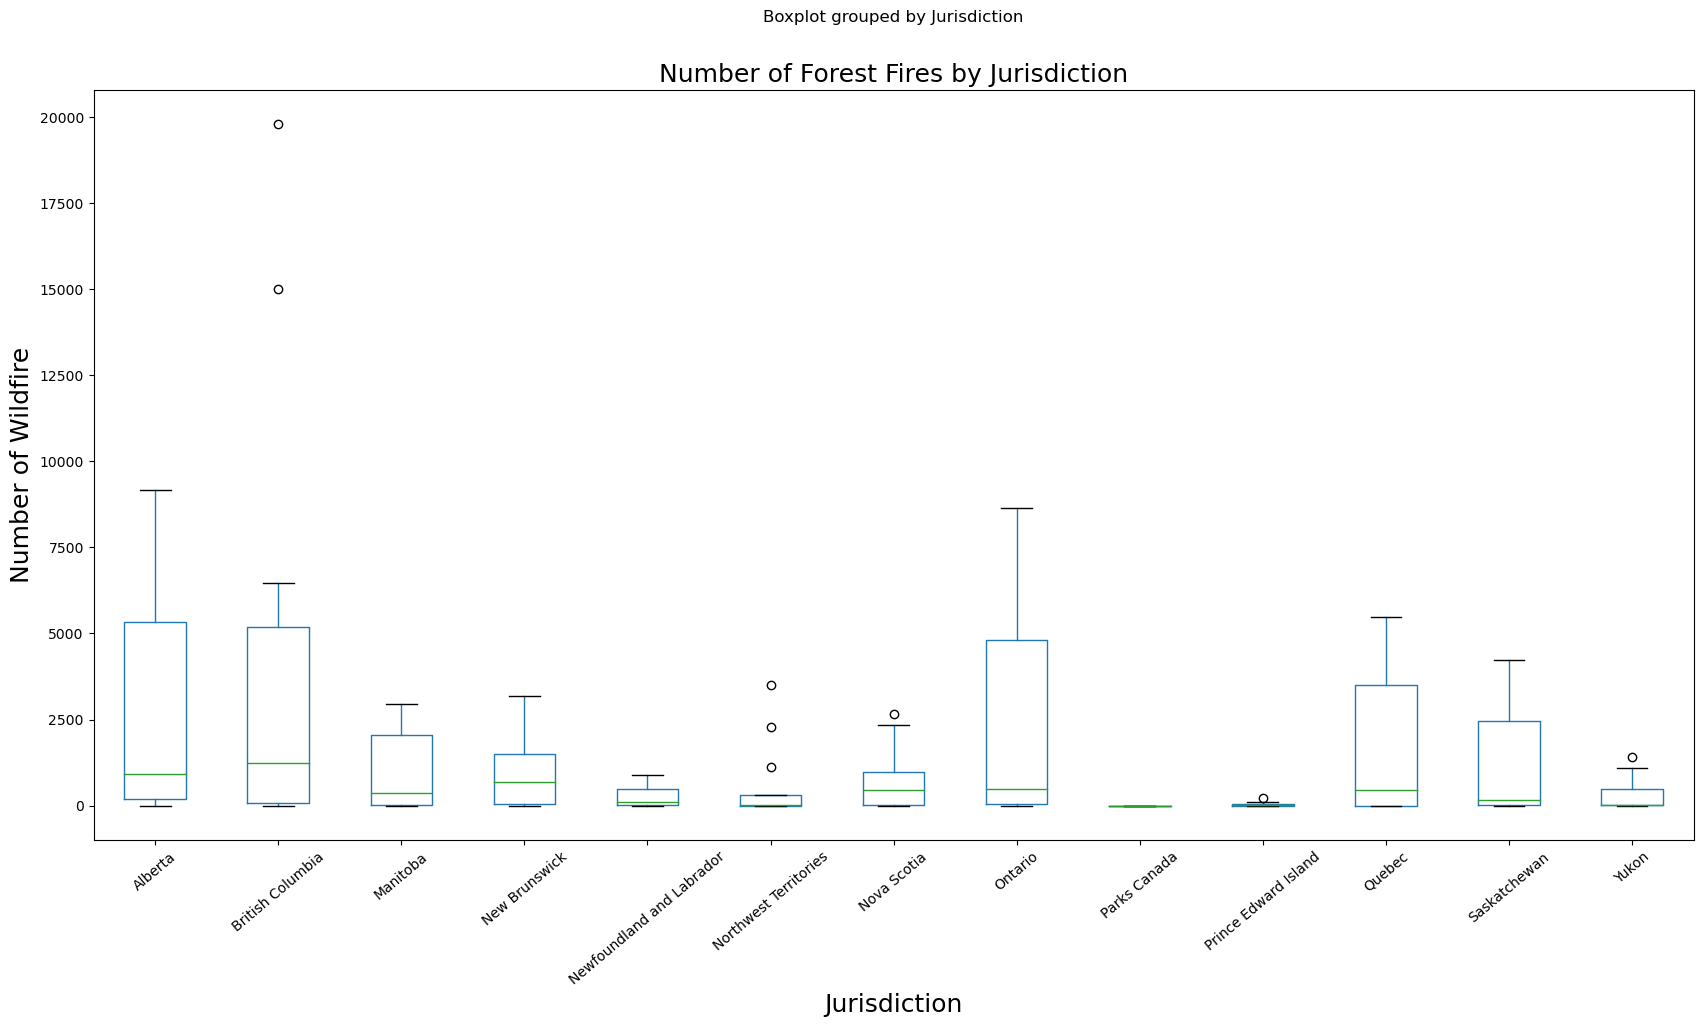

In [160]:
#Since both the extreme datapoints were from British columbia, Plotted a box-plot to see the distribution of data by Jurisdiction
ForestFire_months.boxplot("Total", by="Jurisdiction", figsize=(20, 10), grid=False, rot=40)

# Incorporate the other graph properties:
plt.xlabel('Jurisdiction', fontsize=18)
plt.ylabel('Number of Wildfire', fontsize=18)
plt.title('Number of Forest Fires by Jurisdiction', fontsize=18)

# Save the figure:
plt.savefig('Output_data_NG/Fig.11 - Box-plot_Number of Forest Fires by Jurisdiction.png')
plt.show()


# Observation and Analysis:
    - July and August has witnessed the maximum number of wildfire in from 1990-2020, followed by June amd May
    - These 4 months are the hottest months in Canada, and probably temperature is the main cause of wild fire during these months
    -Excessively large number of wildfires occur in British Columbia during the month of July and August
    -As from the previous data on Causes, Pritish Columbia probably has a very high number of wildfire due to lightning and Temperature during the months of July and August
        